In [1]:
import os
import datetime
import numpy as np

import cv2
from matplotlib import pyplot as plt

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection.anchor_utils import AnchorGenerator

from models.FasterRcnn.dataset import Dataset_MoTe2_2H_withmono, Dataset_MoTe2_2H_withmono_adsorb, Dataset_MoTe2_1T, RandomGenerator, Dataset_MoTe2_2H_withmono_mixpsize, Dataset_MoTe2, Dataset_TEMImagenet
from models.FasterRcnn.trainer import train

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
# 数据集加载
formula = "MoTe2-2H-withmono"
psize = 20
num_pos = 200
num_total = 4000
width = 8
data_file = os.path.join('F:\\QBC\\STEM-Pytorch\\datas', f'data_{formula}_psize={psize}_pos={num_pos}_total={num_total}')
label_file = os.path.join('F:\\QBC\\STEM-Pytorch\\fasterrcnn_labels', f'label_{formula}_psize={psize}_pos={num_pos}_width={width}')

dataset = Dataset_MoTe2_2H_withmono(data_file, label_file, num_pos, num_total, transform=RandomGenerator())
# 计算划分的样本数量
ratio = 0.9
train_size = int(ratio * len(dataset))
valtest_size = len(dataset) - train_size
val_size = int(ratio * valtest_size)
test_size = valtest_size - val_size

# 使用 random_split 函数划分数据集
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(14128))
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
# TEMImagenet
# def custom_collate(batch):
#     images = [item[0] for item in batch]
#     targets = [item[1] for item in batch]
#     return images, targets

dataset = Dataset_TEMImagenet()
# 计算划分的样本数量
ratio = 0.9
train_size = int(ratio * len(dataset))
valtest_size = len(dataset) - train_size
val_size = int(ratio * valtest_size)
test_size = valtest_size - val_size

# 使用 random_split 函数划分数据集
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(14128))
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=16, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
for image, target in train_dataloader:
    print(image.shape)
    print(target)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


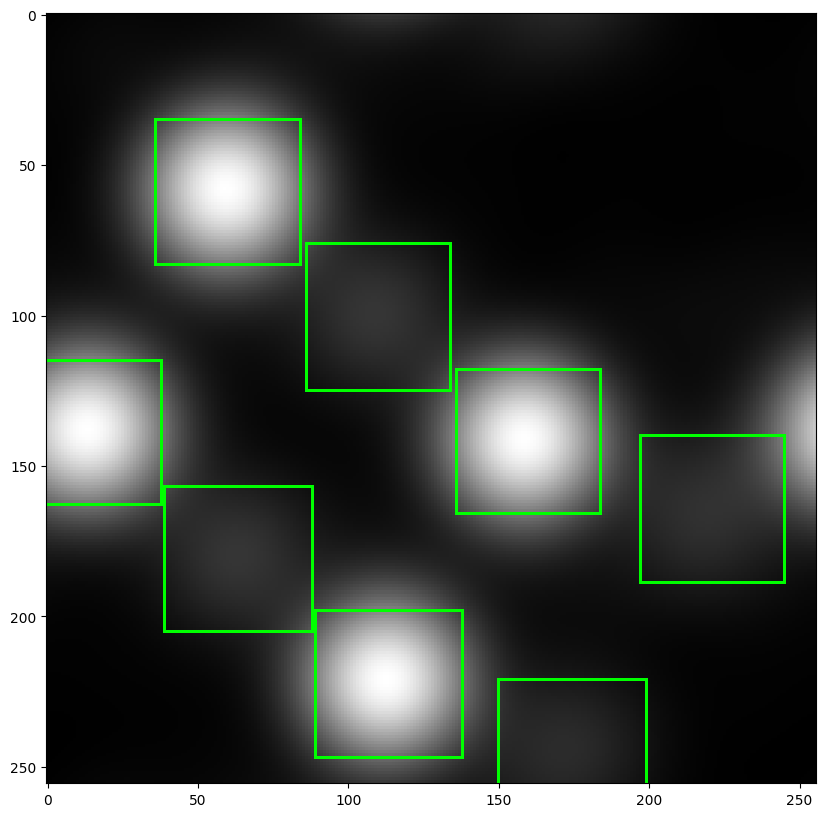

In [22]:
# 数据集验证
index = 6
image, target = test_dataset[index]
boxes = target['boxes']
labels = target['labels']
input = image.numpy().reshape(image.shape[1], image.shape[2])
input = cv2.cvtColor((input-np.min(input))/(np.max(input)-np.min(input)), cv2.COLOR_GRAY2BGR)
for i in range(boxes.shape[0]):
    x1, y1, x2, y2 = boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    if labels[i] == 1:
        color = (0, 255, 0)
    cv2.rectangle(input, (x1, y1), (x2, y2), color, 1)
plt.figure(figsize=(10, 10))
plt.imshow(input)

In [11]:
# 定义参数
epochs = 20
info = 'SGD'
weight_decay = 0.0005
learning_rate_list = [0.01, ]

In [ ]:
# 模型训练
for learning_rate in learning_rate_list:
    # 加载预训练的Faster R-CNN模型
    anchor_generator = AnchorGenerator(sizes=((4,), (8,), (16,), (32,), (64,)), aspect_ratios=((0.5), (1.0), (2.0)))  # 生成anchor的尺寸和长宽比
    model = fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        weights_backbone=ResNet50_Weights.IMAGENET1K_V1,
        min_size=256,
        max_size=256,
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
        box_detections_per_img=1000,
        rpn_anchor_generator=anchor_generator,
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features  # 获取分类器的输入特征数
    num_classes = 1  # 替换预训练模型的头部以适应新的类别数，比如你的数据集有10个类别
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)  # 注意：这里的num_classes包括背景类，所以输入的类别数为num_classes+1
    model.roi_heads.score_thresh = 0
    
    current_time = datetime.datetime.now()
    current_time = datetime.datetime.strftime(current_time, r'%Y%m%d-%H%M%S')
    save_path = os.path.join('results',f'FasterRCNN_{current_time}_lr={learning_rate}_wd={weight_decay}_{info}')
    train(model, device, save_path, train_dataloader, val_dataloader, test_dataloader, num_classes, learning_rate, weight_decay, epochs)

In [4]:
# 模型测试
anchor_generator = AnchorGenerator(sizes=((10,), (12,), (14,), (16,), (18,)), aspect_ratios=((0.5), (1.0), (2.0)))  # 生成anchor的尺寸和长宽比
model = fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        weights_backbone=ResNet50_Weights.IMAGENET1K_V1,
        min_size=204,
        max_size=308,
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
        box_detections_per_img=1000,
        rpn_anchor_generator=anchor_generator,
)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 3
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
model.roi_heads.score_thresh = 0

load_file = os.path.join('result', 'FasterRcnn', 'FasterRCNN_20240308-111337_MoTe2_psize=10_classes=3_lr=0.01_wd=0.0005_width=14_SGD', 'model_10.pth')
model.load_state_dict(torch.load(load_file))
model = model.eval()

In [2]:
load_file = os.path.join('result', 'FasterRcnn', 'FasterRCNN_20240304-100649_MoTe2-2H-withmono_psize=10_classes=3_lr=0.003_wd=0.0005_width=15_SGD', 'full_model.pth')
model = torch.load(load_file)

In [5]:
from models.FasterRcnn.mAP import calculate_mAP, draw_PR
mAP, recalls, precisions = calculate_mAP(model, test_dataloader, num_classes, device)
print(mAP)

1.0


In [ ]:
for i in range(num_classes):
    draw_PR(recalls[i], precisions[i], f"Class {i+1}")

In [37]:
test_data = list(test_dataloader)
model.roi_heads.score_thresh = 0.1
index = 5
image = test_data[index][0]
target = test_data[index][1]
model.to(torch.device('cpu'))
with torch.no_grad():
    prediction = model(image)
predictions = prediction[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


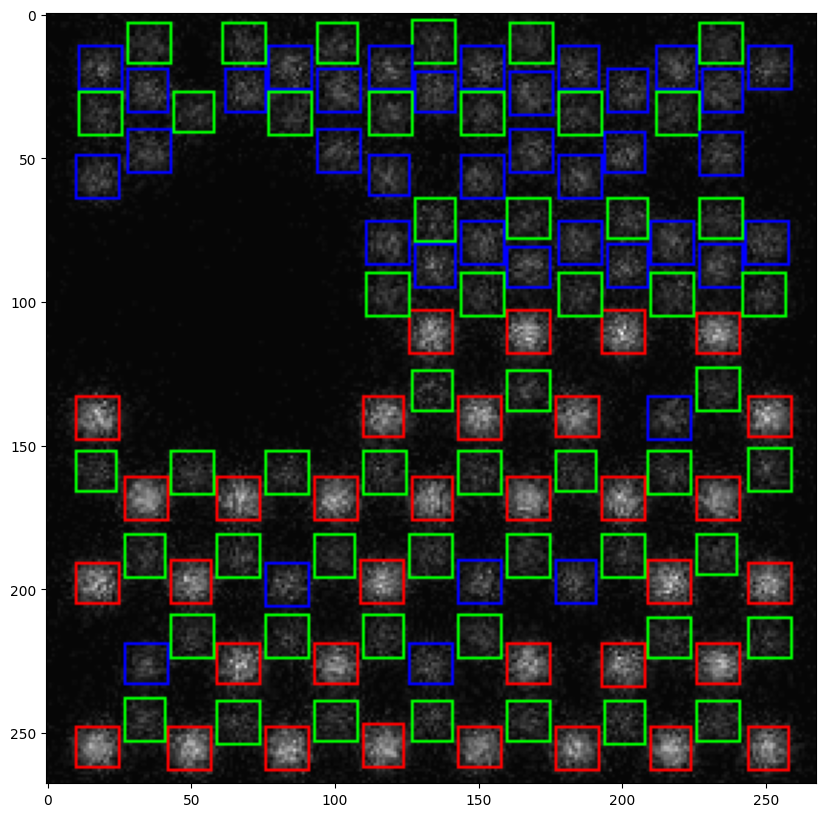

In [38]:
boxes = predictions['boxes']
labels = predictions['labels']
input = image.numpy().reshape(image.shape[2], image.shape[2])
input = cv2.cvtColor((input-np.min(input))/(np.max(input)-np.min(input)), cv2.COLOR_GRAY2BGR)
for i in range(boxes.shape[0]):
    x1, y1, x2, y2 = boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    if labels[i] == 1:
        color = (0, 255, 0)  # mo green
    elif labels[i] == 2:
        color = (0, 0, 255)  # te_single blue
    elif labels[i] == 3:
        color = (255, 0, 0)  # te_double red
    elif labels[i] == 4:
        color = (0, 255, 255)
    else:
        color = (255, 0, 255)
    cv2.rectangle(input, (x1, y1), (x2, y2), color, 1)
plt.figure(figsize=(10, 10))
plt.imshow(input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


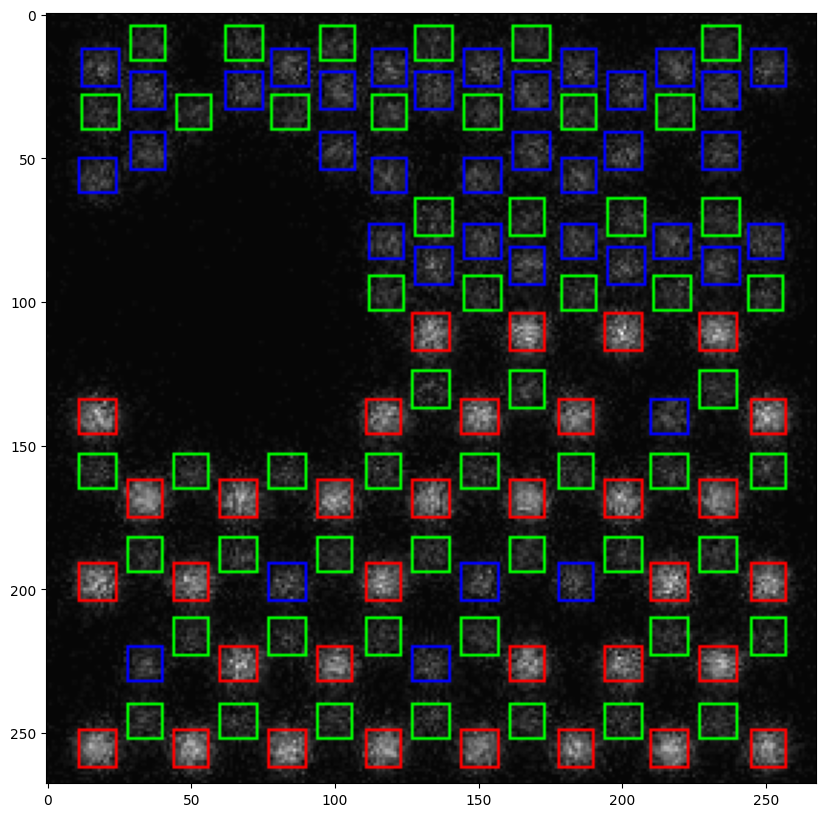

In [39]:
input = image.numpy().reshape(image.shape[2], image.shape[2])
boxes = target['boxes'][0]
labels = target['labels'][0]
input = cv2.cvtColor((input-np.min(input))/(np.max(input)-np.min(input)), cv2.COLOR_GRAY2BGR)
for i in range(boxes.shape[0]):
    x1, y1, x2, y2 = boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    if labels[i] == 1:
        color = (0, 255, 0)  # mo green
    elif labels[i] == 2:
        color = (0, 0, 255)  # te_single blue
    elif labels[i] == 3:
        color = (255, 0, 0)  # te_double red
    elif labels[i] == 4:
        color = (0, 255, 255)
    else:
        color = (255, 0, 255)
    cv2.rectangle(input, (x1, y1), (x2, y2), color, 1)
plt.figure(figsize=(10, 10))
plt.imshow(input)

### STEM图片测试

In [3]:
from utils import load_dm3, denoise, save_as_image
def back_ellimination(EMData):
    radius = 15
    EMData_padded = np.pad(EMData,((radius,radius),(radius,radius)),mode='edge')
    window_shape = (2*radius+1, 2*radius+1)
    strided_EMData = np.lib.stride_tricks.sliding_window_view(EMData_padded,window_shape)
    min_values = np.min(strided_EMData,axis=(-1,-2))
    bkg_filter = EMData - min_values
    return bkg_filter

def data_init(data):
    return (data - np.min(data))/(np.max(data) - np.min(data))

In [ ]:
# 导入电镜图片
filename = './STEM/1345 3.80 Mx STEM HAADF HAADF 12.82pm.dm3'
EMdata1 = data_init(back_ellimination(load_dm3(filename)))
denoisedEM1 = data_init(denoise(EMdata1, subrow=64, subcol=64, step_size=8))

In [ ]:
save_as_image(denoisedEM1, "./STEM/1345_denoised.tif")

In [10]:
filename = './STEM/1345_stem.tif'
EMdata1 = data_init(back_ellimination(load_dm3(filename)))
filename = './STEM/1345_denoised.tif'
denoisedEM1 = data_init(load_dm3(filename))

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(EMdata1, cmap='gray')

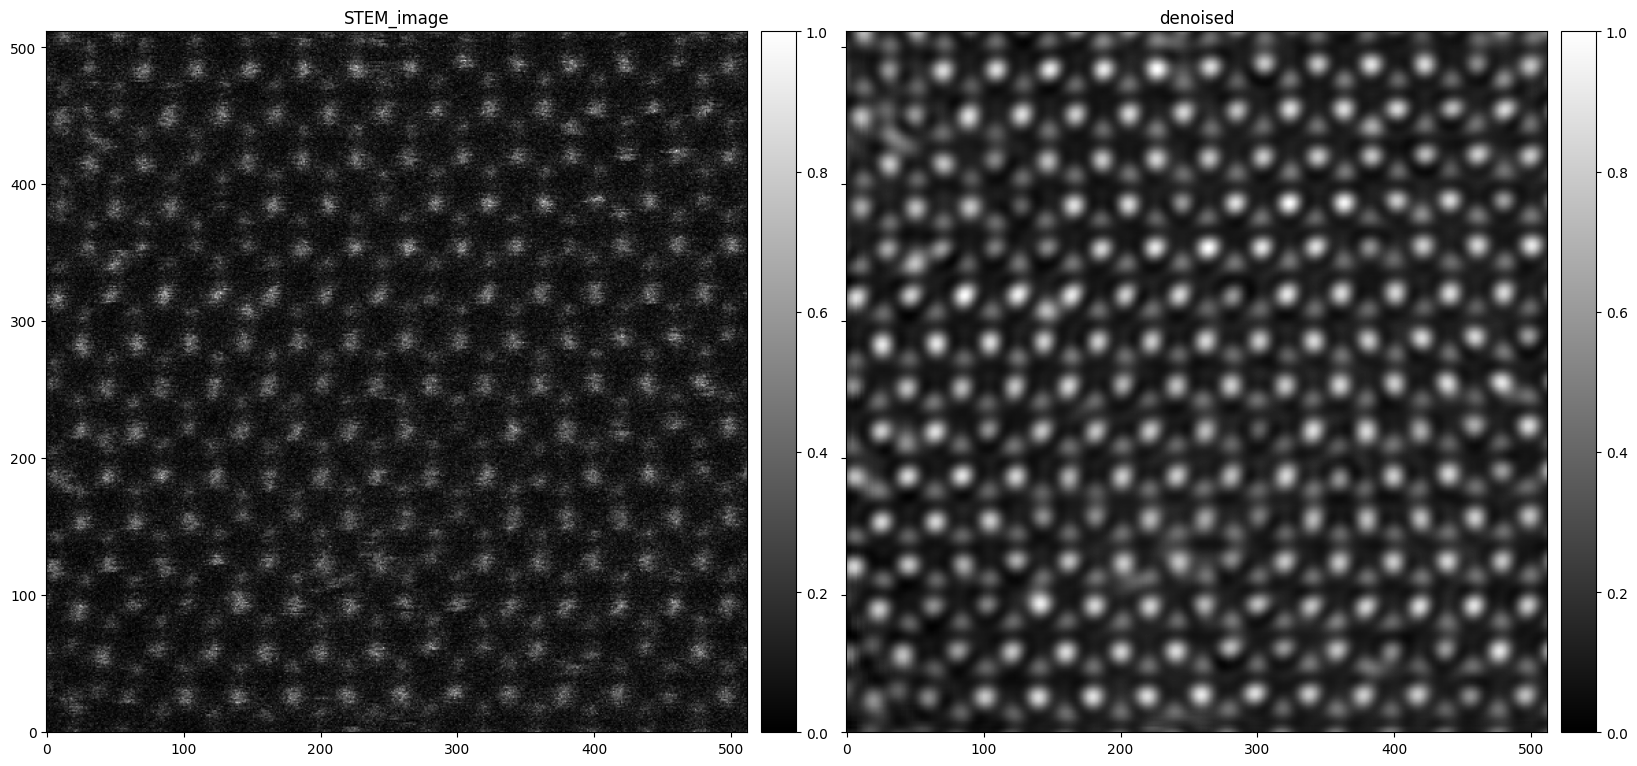

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.5, cbar_mode="each", cbar_size="5%", cbar_pad="2%")
im0 = grid[0].imshow(EMdata1, cmap='gray')
grid[0].invert_yaxis()
grid[0].set_title('STEM_image')
grid.cbar_axes[0].colorbar(im0)
im1 = grid[1].imshow(denoisedEM1, cmap='gray')
grid[1].invert_yaxis()
grid[1].set_title('denoised')
grid.cbar_axes[1].colorbar(im1)
plt.show()

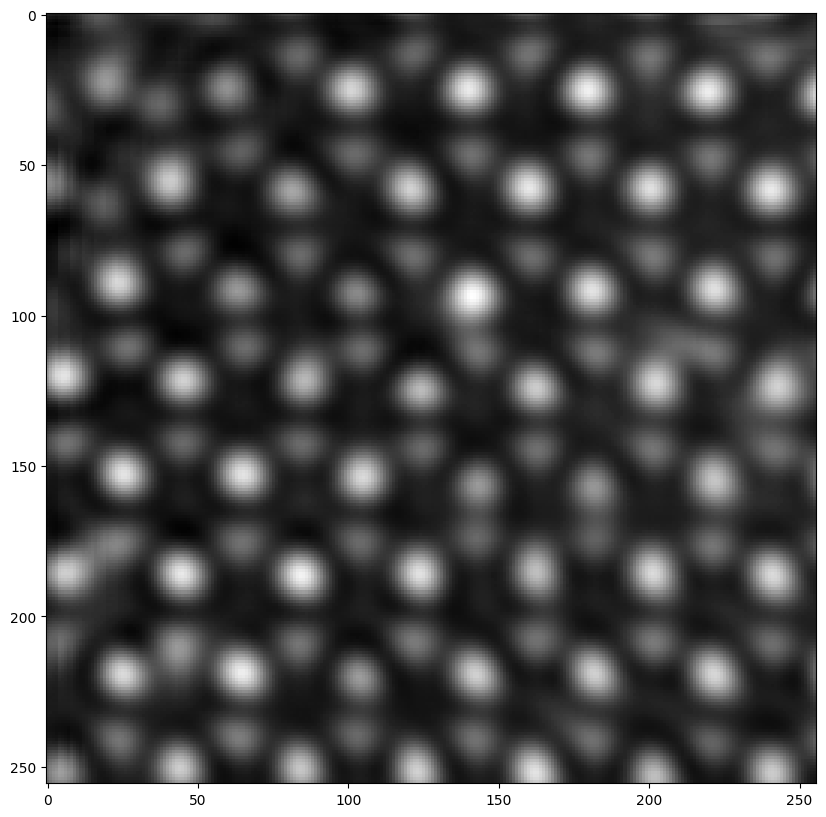

In [7]:
test_input = denoisedEM1[0:256, 0:256]
plt.figure(figsize=(10, 10))
plt.imshow(test_input, cmap='gray')

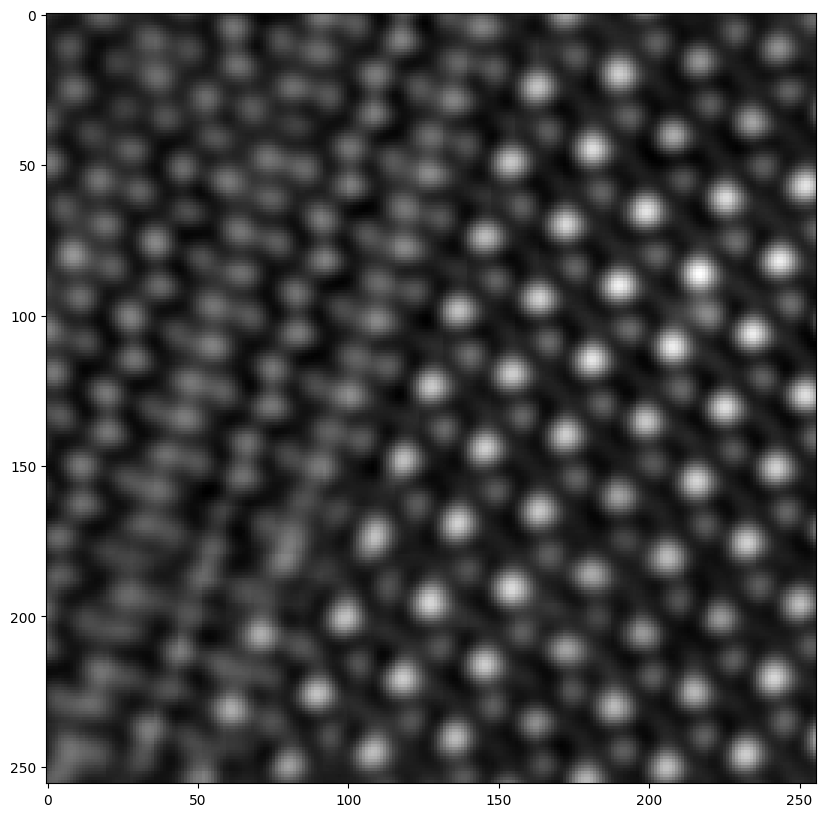

In [9]:
test_input = data_init(denoisedEM1[1100:1356, 1100:1356])
plt.figure(figsize=(10, 10))
plt.imshow(test_input, cmap='gray')

In [8]:
model.to(torch.device('cpu'))
model.roi_heads.score_thresh = 0.1
with torch.no_grad():
    input_image = torch.Tensor(test_input).unsqueeze(0).unsqueeze(0)
    prediction = model(input_image)
predictions = prediction[0]

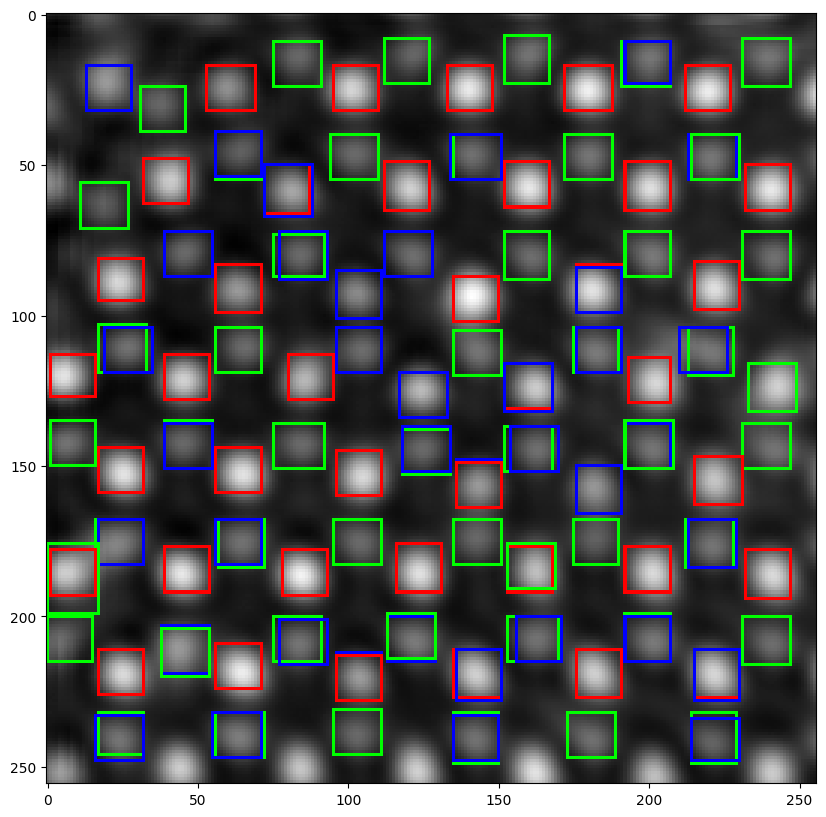

In [9]:
boxes = predictions['boxes']
labels = predictions['labels']

input_image = test_input
input_image = cv2.cvtColor((input_image-np.min(input_image))/(np.max(input_image)-np.min(input_image)), cv2.COLOR_GRAY2BGR)
for i in range(boxes.shape[0]):
    x1, y1, x2, y2 = boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    if labels[i] == 1:
        color = (0, 255, 0)  # mo_2H green
    elif labels[i] == 2:
        color = (0, 0, 255)  # te_single_2H blue
    elif labels[i] == 3:
        color = (255, 0, 0)  # te_double_2H red
    elif labels[i] == 4:
        color = (0, 255, 255)  # mo_1T
    else:
        color = (255, 0, 255) # mo_te_single_1T
    cv2.rectangle(input_image, (x1, y1), (x2, y2), color, 1)
plt.figure(figsize=(10, 10))
plt.imshow(input_image)